In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [2]:
#Create a Portfolio
symbols = ['AAPL','MSFT', 'META','AMZN','XOM','UNH','JNJ','V', 'HD','ABBV','KO','DIS','T','UPS','LMT','CAT', 'F','MAR','O', 'HSY']
portfolio = yf.download(symbols, start="2018-01-01", end="2023-02-28")['Adj Close']

portfolio.head()

[*********************100%%**********************]  20 of 20 completed


,AAPL,ABBV,AMZN,CAT,DIS,F,HD,HSY,JNJ,KO,LMT,MAR,META,MSFT,O,T,UNH,UPS,V,XOM
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.722885,74.990387,59.450500,135.989395,108.726059,9.496590,162.567657,98.511215,118.394844,37.655880,271.792267,127.620255,181.419998,80.228996,42.033039,18.058529,202.505463,102.050980,109.938263,63.220589
2018-01-03,40.715794,76.163895,60.209999,136.197220,109.192848,9.571605,163.414963,98.098236,119.525818,37.573181,274.070435,130.196472,184.669998,80.602402,41.921673,17.641506,204.629791,104.311989,111.032738,64.462234
2018-01-04,40.904911,75.729546,60.479500,138.067734,109.144241,9.736630,164.711807,98.783600,119.517319,38.102386,278.771820,129.480835,184.330002,81.311806,41.015995,17.805508,205.517944,104.988640,111.445595,64.551483
2018-01-05,41.370621,77.047852,61.457001,140.249893,108.551003,9.901656,166.432327,99.258110,120.503761,38.094120,281.297394,128.240433,186.850006,82.319893,40.986309,17.871105,209.436890,105.310463,114.114571,64.499435
2018-01-08,41.216961,75.813385,62.343498,143.774353,106.994995,9.864152,166.034622,100.224678,120.656792,38.036236,280.000458,130.091568,188.279999,82.403900,41.038258,17.922649,205.801804,106.589493,114.575409,64.789413


In [3]:
#market Benchmark
market_prices = yf.download("SPY", start='2018-01-01', end='2023-02-28')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02    244.057755
2018-01-03    245.601517
2018-01-04    246.636642
2018-01-05    248.280228
2018-01-08    248.734253
Name: Adj Close, dtype: float64

In [4]:
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 3031551705088,
 'MSFT': 2756327768064,
 'META': 840125841408,
 'AMZN': 1527881924608,
 'XOM': 394081533952,
 'UNH': 506308591616,
 'JNJ': 375631970304,
 'V': 524474384384,
 'HD': 324848549888,
 'ABBV': 260223123456,
 'KO': 254497538048,
 'DIS': 170366189568,
 'T': 122253901824,
 'UPS': 133922766848,
 'LMT': 110947393536,
 'CAT': 130497568768,
 'F': 43271888896,
 'MAR': 61099474944,
 'O': 39841157120,
 'HSY': 38657282048}

In [5]:
#sigma and delta for implied market returns
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.090708947145048

<Axes: >

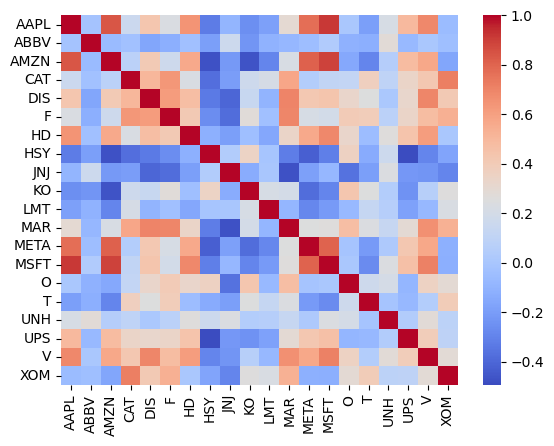

In [6]:
#Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

In [7]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.178708
ABBV    0.088660
AMZN    0.171277
CAT     0.112621
DIS     0.124194
F       0.126746
HD      0.126232
HSY     0.070029
JNJ     0.076076
KO      0.078743
LMT     0.082315
MAR     0.125698
META    0.186111
MSFT    0.171233
O       0.096254
T       0.079788
UNH     0.112862
UPS     0.110402
V       0.136997
XOM     0.099119
dtype: float64

In [8]:
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'META':0.05,
    'AMZN':0.30,
    'XOM':0.02,
    'UNH':0.01,
    'JNJ':0.15,
    'V':0.09,
    'HD':0.16,
    'ABBV':0.07,
    'KO':0.01,
    'DIS':-0.23,
    'T':0.16,
    'UPS':0.10,
    'LMT':-0.09,
    'CAT':0.30,
    'F':0.16,
    'MAR':-0.08,
    'O':0.30,
    'HSY':-0.26
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [9]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
]

In [10]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


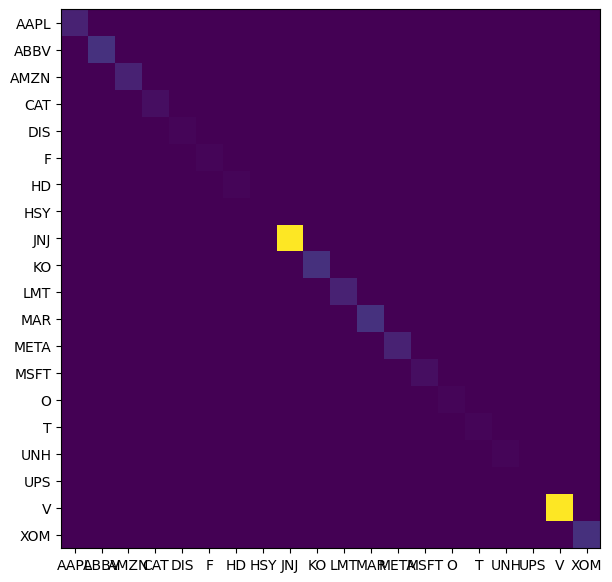

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [12]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [13]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.145397
ABBV    0.062536
AMZN    0.199000
CAT     0.185927
DIS     0.045060
F       0.128789
HD      0.095764
HSY     0.009729
JNJ     0.082854
KO      0.032213
LMT    -0.008295
MAR    -0.064687
META    0.140892
MSFT    0.142702
O       0.004325
T       0.060260
UNH     0.042522
UPS     0.101215
V       0.086599
XOM     0.042052
dtype: float64

In [14]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.178708,0.145397,0.10
ABBV,0.088660,0.062536,0.07
AMZN,0.171277,0.199000,0.30
CAT,0.112621,0.185927,0.30
DIS,0.124194,0.045060,-0.23
F,0.126746,0.128789,0.16
HD,0.126232,0.095764,0.16
HSY,0.070029,0.009729,-0.26
JNJ,0.076076,0.082854,0.15
KO,0.078743,0.032213,0.01


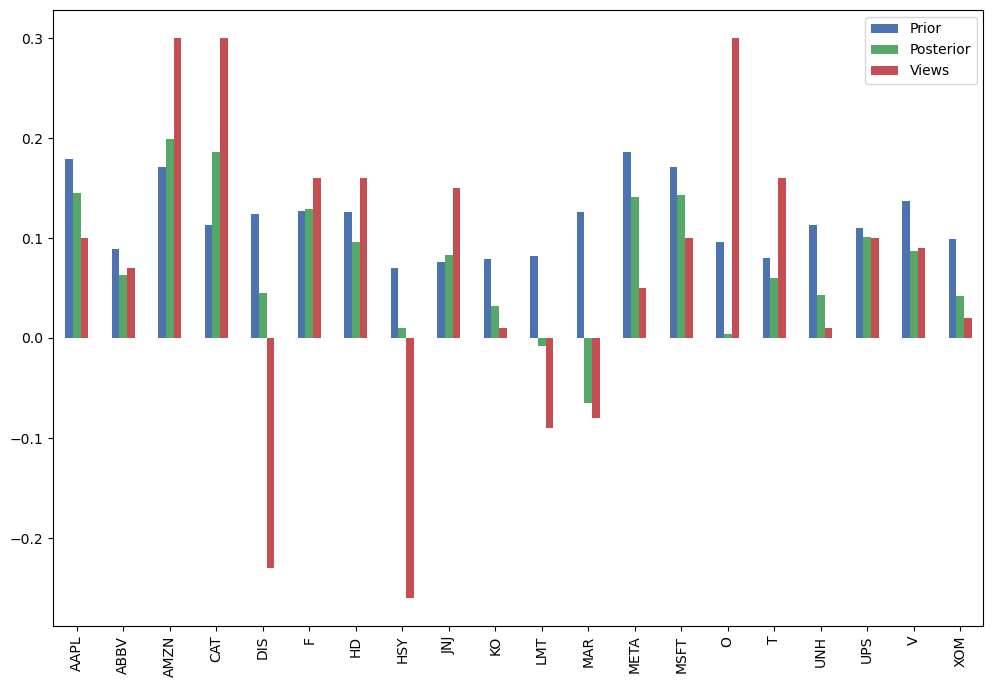

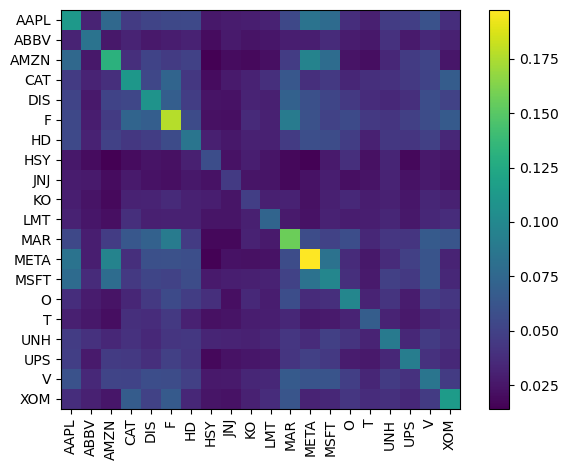

In [17]:
rets_df.plot.bar(figsize=(12,8));
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [18]:
#allocation:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/oliverw/anaconda3/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.10632),
             ('ABBV', 0.02654),
             ('AMZN', 0.17611),
             ('CAT', 0.17126),
             ('DIS', 0.0),
             ('F', 0.08531),
             ('HD', 0.05342),
             ('HSY', 0.0),
             ('JNJ', 0.05995),
             ('KO', 0.0),
             ('LMT', 0.0),
             ('MAR', 0.0),
             ('META', 0.08995),
             ('MSFT', 0.10423),
             ('O', 0.0),
             ('T', 0.02425),
             ('UNH', 0.0),
             ('UPS', 0.06448),
             ('V', 0.03817),
             ('XOM', 0.0)])

In [19]:
#visualised weight:

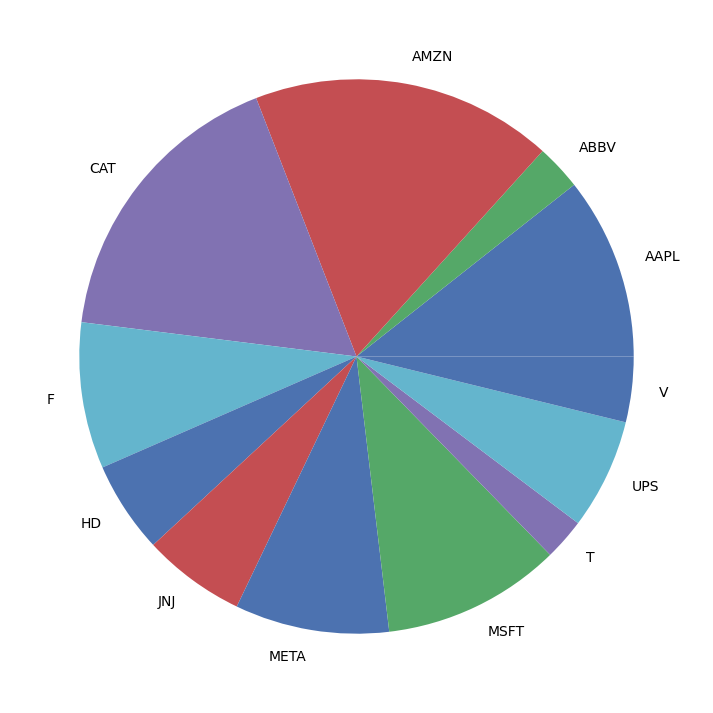

In [20]:
pd.Series(weights).plot.pie(figsize=(9,9));


Expected annual return: 14.4%
Annual volatility: 24.1%
Sharpe Ratio: 0.51


/Users/oliverw/anaconda3/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/oliverw/anaconda3/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.14391687700301642, 0.2413838431341712, 0.5133602787744922)

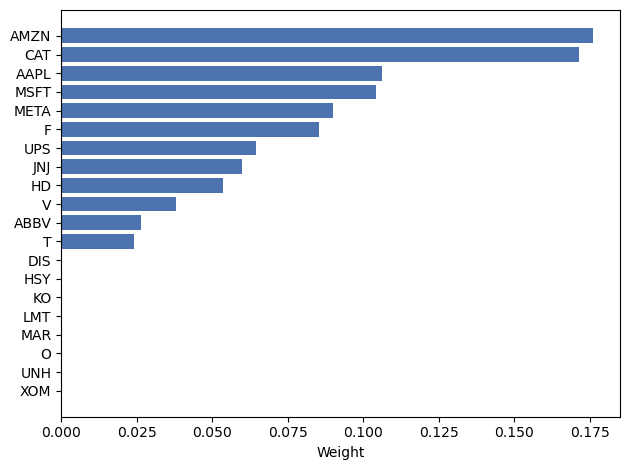

In [21]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)
